# Geographic Features

Author: Vincent

Last Update: 2024-05-02

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

In [3]:
import copy
import warnings

In [4]:
warnings.filterwarnings('ignore')
%matplotlib inline

## Load Dataset

In [5]:
df_price = pd.read_csv('price_transform.csv')

In [6]:
df_price.head()

,apartment_id,city,exclusive_use_area,floor,latitude,longitude,address_by_law,total_parking_capacity_in_site,total_household_count_in_sites,apartment_building_count_in_sites,...,heat_type_-,heat_type_district,heat_type_central,heat_type_individual,heat_fuel_-,heat_fuel_cogeneration,heat_fuel_gas,transaction_date_21~31,transaction_date_1~10,transaction_date_11~20
0,5584,1,-1.144215,-0.574122,37.585965,127.000231,1111017100,-0.747549,-0.926899,-0.839598,...,0,0,0,1,0,0,1,0,0,1
1,5584,1,-1.253498,-0.296118,37.585965,127.000231,1111017100,-0.747549,-0.926899,-0.839598,...,0,0,0,1,0,0,1,0,0,1
2,5059,1,-0.884577,-0.296118,37.580511,127.014016,1111017400,-0.249759,-0.528882,-0.553712,...,0,0,0,1,0,0,1,0,0,1
3,2816,1,-0.528869,0.120889,37.580324,127.011788,1111017400,-0.249759,-0.232807,-0.410768,...,0,0,0,1,0,0,1,0,0,1
4,2816,1,0.969673,-0.435120,37.580324,127.011788,1111017400,-0.249759,-0.232807,-0.410768,...,0,0,0,1,0,0,1,0,0,1


In [7]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601458 entries, 0 to 1601457
Data columns (total 37 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   apartment_id                        1601458 non-null  int64  
 1   city                                1601458 non-null  int64  
 2   exclusive_use_area                  1601458 non-null  float64
 3   floor                               1601458 non-null  float64
 4   latitude                            1601458 non-null  float64
 5   longitude                           1601458 non-null  float64
 6   address_by_law                      1601458 non-null  int64  
 7   total_parking_capacity_in_site      1601458 non-null  float64
 8   total_household_count_in_sites      1601458 non-null  float64
 9   apartment_building_count_in_sites   1601458 non-null  float64
 10  tallest_building_in_sites           1601458 non-null  float64
 11  lowest_buil

In [8]:
df_school = pd.read_csv('school_transform.csv')

In [9]:
df_subway = pd.read_csv('subway_transform.csv')

## Regional Dataset

In [10]:
df_seoul = df_price[df_price['city'] == 0]
df_busan = df_price[df_price['city'] == 1]

## General Tools

In [11]:
def regression_report(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained = explained_variance_score(y_test, y_pred)
    return """mse: %.3f
mae: %.3f
r2: %.3f
explained variance score: %.3f
""" % (mse, mae, r2, explained)

In [12]:
def regressor_prediction(regressor, df, features, output):
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[output])
    y_pred = regressor.fit(X_train, y_train).predict(X_test)
    print(regression_report(y_test, y_pred))

In [13]:
FLAT_FEATURES = [
    'supply_area',
    'use_area_ratio',
    'exclusive_use_area',
    'heat_fuel_cogeneration', 
     # compare with other location feature
    'address_by_law'
]

In [14]:
def extract_cluster_feature(df, features):
    kmeans = KMeans()
    kmeans.fit(df[features])
    df['cluster'] = kmeans.labels_

## Seoul

**Location clustering feature**

<Axes: xlabel='longitude', ylabel='latitude'>

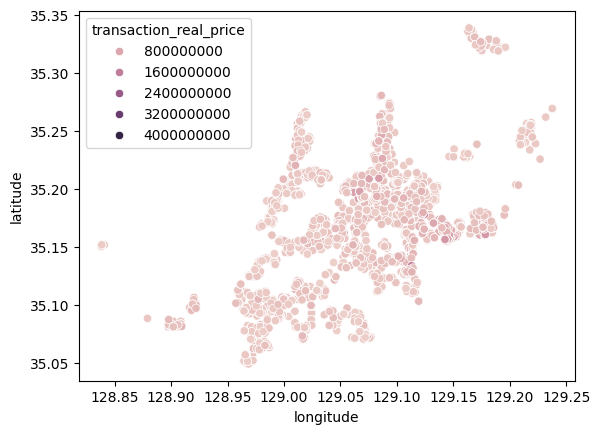

In [38]:
sns.scatterplot(data=df_seoul, x="longitude", y="latitude", hue='transaction_real_price')

In [39]:
extract_cluster_feature(df_seoul, ['latitude',  'longitude'])

In [40]:
# original prediction
regressor_prediction(DecisionTreeRegressor(random_state=42), df_seoul, FLAT_FEATURES, 'transaction_real_price')

mse: 3122773057863861.500
mae: 42382155.484
r2: 0.890
explained variance score: 0.890



This proves that location clustered id is insignificant feature, not comparable to supply_area or use_area_ratio. 

**Count of Subway**

In [41]:
df_subway_seoul = df_subway[df_subway['city'] == 0]

In [42]:
RANGE = max(df_subway_seoul['latitude']) - min(df_subway_seoul['latitude']) + max(df_subway_seoul['longitude']) - min(df_subway_seoul['longitude'])
RANGE = RANGE * 0.1 # 1/10 of all distance
RANGE

0.053029031999997756

(array([ 53068.,  49955., 150034., 108712.,  62041.,  68393.,  70731.,
         32973.,   3400.,    779.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <BarContainer object of 10 artists>)

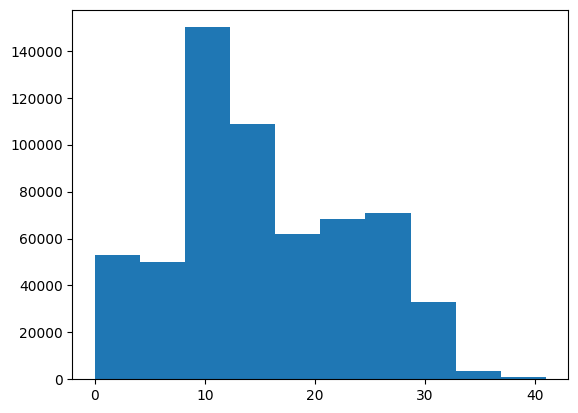

In [43]:
# find feature importance via Decision Tree regressor
A = df_seoul[['longitude', 'latitude']].to_numpy()
B = df_subway_seoul[['longitude', 'latitude']].to_numpy()

# Calculate the Manhattan distance between each element of A and B
manhattan_dist = np.abs(A[:, np.newaxis, :] - B).sum(axis=2)
in_range = manhattan_dist < RANGE
subway_cnt = np.sum(in_range, axis=1)

df_seoul['subway_count'] = subway_cnt

plt.hist(subway_cnt)

**Distinct Subway and Has Subway**

In [44]:
def filter_subway(df):
    remove_columns = [_ for _ in df.columns if (df[_] == 0).all()]
    df.drop(remove_columns, axis=1, inplace=True)

In [45]:
filter_subway(df_subway_seoul)

In [46]:
df_subway_seoul.head()

,station_id,latitude,longitude,address_by_law,line__B3,line__B4,line__B2,line__BD,line__BK,line__B1
278,593,35.095226,128.960633,2.638010e+09,0,0,0,0,0,1
279,594,35.106218,128.966621,2.638010e+09,0,0,0,0,0,1
280,595,35.103576,128.973653,2.638010e+09,0,0,0,0,0,1
281,596,35.099801,128.983217,2.638010e+09,0,0,0,0,0,1
282,597,35.099924,128.992507,2.638010e+09,0,0,0,0,0,1


In [47]:
SUBWAY_LINE_SEOUL = ['line__B3', 'line__B4', 'line__B2', 'line__BD', 'line__BK', 'line__B1']

lines = df_subway_seoul[SUBWAY_LINE_SEOUL].to_numpy()
distinct_line = np.count_nonzero(in_range @ lines, axis=1)

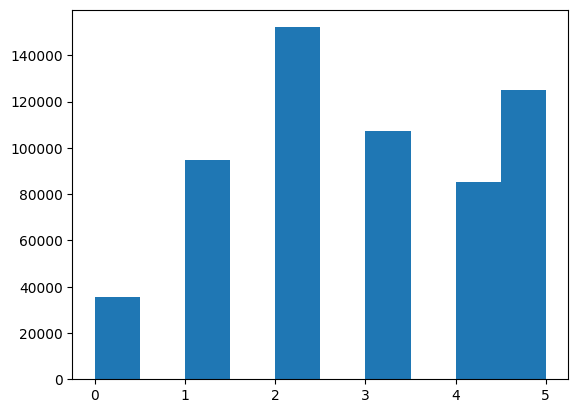

In [48]:
plt.hist(distinct_line)
plt.show()

In [49]:
has_line = distinct_line > 0

df_seoul['distinct_line'] = distinct_line
df_seoul['has_subway'] = has_line

**count of school**

In [50]:
df_school_seoul = df_school[df_school['city'] == 0]

In [51]:
RANGE_SCHOOL = max(df_school_seoul['latitude']) - min(df_school_seoul['latitude']) + max(df_school_seoul['longitude']) - min(df_school_seoul['longitude'])
RANGE_SCHOOL = RANGE_SCHOOL * 0.01 # 1 / 100 of all school distance
RANGE_SCHOOL

0.007624299299999962

(array([7.34190e+04, 1.04801e+05, 1.46942e+05, 1.87365e+05, 4.20650e+04,
        3.30890e+04, 9.76600e+03, 8.42000e+02, 1.79400e+03, 3.00000e+00]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

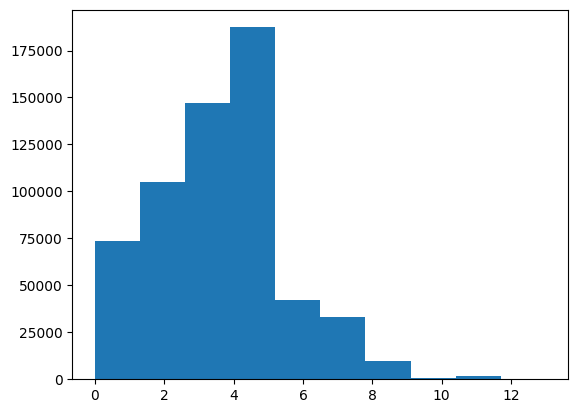

In [52]:
A = df_seoul[['longitude', 'latitude']].to_numpy()
C = df_school_seoul[['longitude', 'latitude']].to_numpy()

manhattan_dist_school = np.abs(A[:, np.newaxis, :] - C).sum(axis=2)
in_range_school = manhattan_dist_school < RANGE_SCHOOL
school_cnt = np.sum(in_range_school, axis=1)

df_seoul['school_count'] = school_cnt

plt.hist(school_cnt)

**Compare Feature Importance**

In [53]:
regressor_prediction(DecisionTreeRegressor(random_state=42), df_seoul, FLAT_FEATURES, 'transaction_real_price')

mse: 3110206790580269.500
mae: 42238474.606
r2: 0.893
explained variance score: 0.893



In [54]:
# find feature importance via Decision Tree regressor
LOC_FEATURES = ['cluster', 'subway_count', 'distinct_line', 'has_subway', 'school_count']
dt = DecisionTreeRegressor(random_state=42)
regressor_prediction(dt, df_seoul, FLAT_FEATURES + LOC_FEATURES, 'transaction_real_price')
pd.DataFrame(data={
    'feature':dt.feature_names_in_, 
    'importance': dt.feature_importances_
}).sort_values(by='importance', ascending=False)

mse: 3092481332163240.500
mae: 42253833.011
r2: 0.890
explained variance score: 0.890



,feature,importance
0,supply_area,0.713652
1,use_area_ratio,0.124479
2,exclusive_use_area,0.046715
4,address_by_law,0.043981
9,school_count,0.024280
6,subway_count,0.021135
7,distinct_line,0.013566
5,cluster,0.008987
3,heat_fuel_cogeneration,0.003066
8,has_subway,0.000138


## Busan

<Axes: xlabel='longitude', ylabel='latitude'>

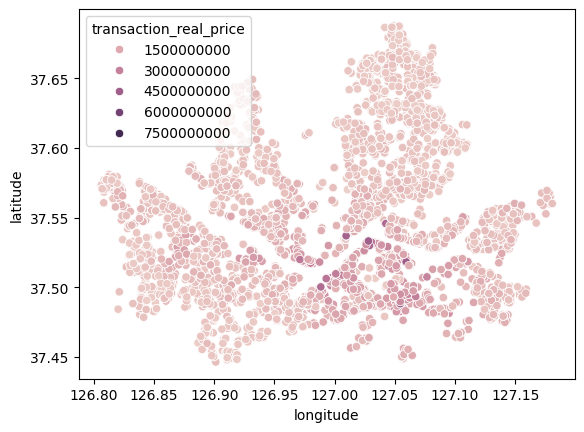

In [32]:
sns.scatterplot(data=df_busan, x="longitude", y="latitude", hue='transaction_real_price')

**Location clustering feature**

In [15]:
extract_cluster_feature(df_busan, ['latitude',  'longitude'])

In [16]:
# original prediction
regressor_prediction(DecisionTreeRegressor(random_state=42), df_busan, FLAT_FEATURES, 'transaction_real_price')

mse: 11153126317631484.000
mae: 66402580.938
r2: 0.908
explained variance score: 0.908



This proves that location clustered id is insignificant feature, not comparable to supply_area or use_area_ratio. 

**Count of Subway**

In [17]:
df_subway_busan = df_subway[df_subway['city'] == 1]

In [21]:
RANGE = max(df_subway_busan['latitude']) - min(df_subway_busan['latitude']) + max(df_subway_busan['longitude']) - min(df_subway_busan['longitude'])
RANGE = RANGE * 0.1 # 1/10 of all distance
RANGE

0.06111107400000009

(array([ 25037., 101643., 168285., 172025., 197063., 147966., 103185.,
         41399.,  25364.,  19405.]),
 array([ 4. , 10.9, 17.8, 24.7, 31.6, 38.5, 45.4, 52.3, 59.2, 66.1, 73. ]),
 <BarContainer object of 10 artists>)

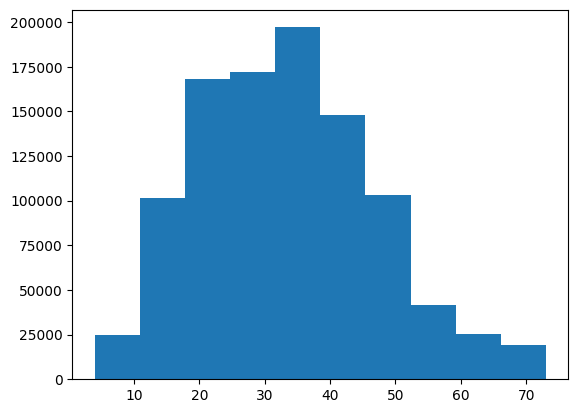

In [22]:
# find feature importance via Decision Tree regressor
A = df_busan[['longitude', 'latitude']].to_numpy()
B = df_subway_busan[['longitude', 'latitude']].to_numpy()

# Calculate the Manhattan distance between each element of A and B
manhattan_dist = np.abs(A[:, np.newaxis, :] - B).sum(axis=2)
in_range = manhattan_dist < RANGE
subway_cnt = np.sum(in_range, axis=1)

df_busan['subway_count'] = subway_cnt

plt.hist(subway_cnt)

**Distinct Subway and Has Subway**

In [23]:
def filter_subway(df):
    remove_columns = [_ for _ in df.columns if (df[_] == 0).all()]
    df.drop(remove_columns, axis=1, inplace=True)

In [24]:
filter_subway(df_subway_busan)

In [25]:
df_subway_busan.head()

,station_id,latitude,longitude,address_by_law,city,line__AP,line__2,line__KJ,line__4,line__1,line__3,line__7,line__6,line__9,line__ND,line__KC,line__5,line__8,line__DL,line__US
0,1,37.555729,126.972145,1.114012e+09,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0
1,2,37.565624,126.976936,1.114017e+09,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,37.570169,126.983099,1.111013e+09,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,4,37.571570,126.991895,1.111016e+09,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
4,5,37.570988,127.001921,1.111016e+09,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [26]:
SUBWAY_LINE_BUSAN = ['line__1', 'line__2', 'line__3', 'line__4', 'line__5', 'line__6', 'line__7', 'line__8',
                    'line__AP', 'line__KJ', 'line__ND', 'line__KC', 'line__DL', 'line__US']

lines = df_subway_busan[SUBWAY_LINE_BUSAN].to_numpy()
distinct_line = np.count_nonzero(in_range @ lines, axis=1)

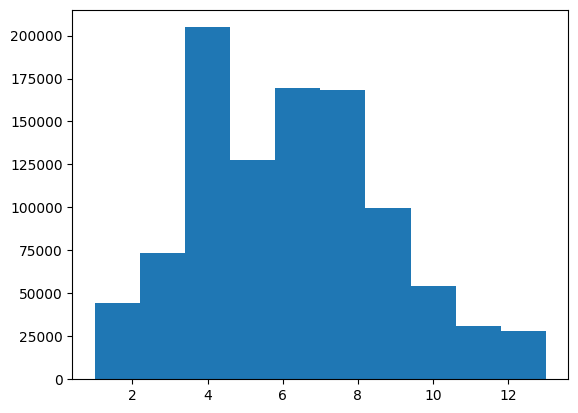

In [27]:
plt.hist(distinct_line)
plt.show()

In [28]:
has_line = distinct_line > 0

df_busan['distinct_line'] = distinct_line
df_busan['has_subway'] = has_line

**count of school**

In [29]:
df_school_busan = df_school[df_school['city'] == 1]

In [34]:
RANGE_SCHOOL = max(df_school_busan['latitude']) - min(df_school_busan['latitude']) + max(df_school_busan['longitude']) - min(df_school_busan['longitude'])
RANGE_SCHOOL = RANGE_SCHOOL * 0.01 # 1 / 100 of all school distance
RANGE_SCHOOL

0.0062145478000000766

(array([ 64399., 165324., 214079., 234191., 133484., 107096.,  53028.,
         23371.,   4782.,   1618.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

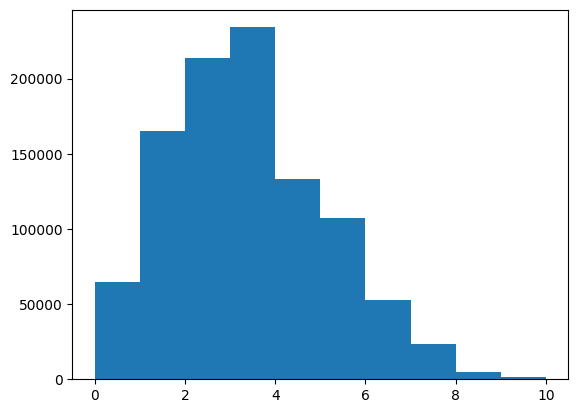

In [35]:
# run a LONG LNOG TIME
A = df_busan[['longitude', 'latitude']].to_numpy()
C = df_school_busan[['longitude', 'latitude']].to_numpy()

manhattan_dist_school = np.abs(A[:, np.newaxis, :] - C).sum(axis=2)
in_range_school = manhattan_dist_school < RANGE_SCHOOL
school_cnt = np.sum(in_range_school, axis=1)

df_busan['school_count'] = school_cnt

plt.hist(school_cnt)

**Compare Feature Importance**

In [36]:
regressor_prediction(DecisionTreeRegressor(random_state=42), df_busan, FLAT_FEATURES, 'transaction_real_price')

mse: 11122069274452752.000
mae: 66350510.077
r2: 0.911
explained variance score: 0.911



In [37]:
# find feature importance via Decision Tree regressor
LOC_FEATURES = ['cluster', 'subway_count', 'distinct_line', 'has_subway', 'school_count']
dt = DecisionTreeRegressor(random_state=42)
regressor_prediction(dt, df_busan, FLAT_FEATURES + LOC_FEATURES, 'transaction_real_price')
pd.DataFrame(data={
    'feature':dt.feature_names_in_, 
    'importance': dt.feature_importances_
}).sort_values(by='importance', ascending=False)

mse: 11090516222336940.000
mae: 66482982.360
r2: 0.910
explained variance score: 0.910



,feature,importance
2,exclusive_use_area,0.440460
4,address_by_law,0.281867
0,supply_area,0.116567
6,subway_count,0.064205
7,distinct_line,0.022423
3,heat_fuel_cogeneration,0.022249
1,use_area_ratio,0.020731
5,cluster,0.017416
9,school_count,0.014083
8,has_subway,0.000000
